# Algoritmo Genético para calcular el parámetro de Hubble $H(z)$

Avances hasta ahora: 

1. Empezamos con una poblacion base de funciones y otra de operaciones
2. Se crea la generación 0 combinando estas dos poblaciones bases
3. Se seleccionan individuos de la población 0 a partir del valor de su $\Chi^2$
4. Estos se combinan de a pares, de forma tal que al final de la combinación queda el mismo numero de individuos de la poblacion 0
5. Se escogen aleatoriamente algunos para mutarlos
6. Se crea generación nueva

Errores: 
1. No sé porqué a veces el chi me da un numero imaginario
2. Creo que  en el nueva generación debería conservar individuos de la antigua, y que dentro de esta no solo esten los productos de la combinación/mutación -> quizá conservar en cada iteración a las funciones con menor chi, y a las con menor combinarlas entre ellas. 

Falta: 
1. Conservar algunos individuos de la generacion anterior

In [514]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sympy import symbols, sympify, lambdify, compose, I, pi, log, exp, simplify
from sympy.abc import x
import time

In [515]:
# Extracción de datos

columna1 = []
columna2 = []
columna3 = []

with open('c:/Users/ximen/Desktop/Practicas DFI/hub_data_3.txt', 'r') as archivo:
    # Lee cada línea del archivo
    for linea in archivo: #cada linea es una fila del texto
        elementos = linea.split() # divide la línea en sus elementos utilizando espacios como delimitadores
        #print(elementos)
        columna1.append(elementos[0]) # Agrega cada elemento a su respectiva columna
        columna2.append(elementos[1])
        columna3.append(elementos[2])

z = np.zeros(len(columna1))
for i in range(len(columna1)):
  z[i] = float(columna1[i])

H = np.zeros(len(columna2))
for i in range(len(columna2)):
  H[i] = float(columna2[i])

desv = np.zeros(len(columna3))
for i in range(len(columna3)):
  desv[i] = float(columna3[i])

print(desv)

[19.6  12.   26.2   8.    4.    5.   29.6  14.   36.6   8.4  14.   13.5
 17.   10.2  11.2   7.8  12.9   9.   50.   62.    3.4  13.    6.1   8.
  7.   33.6  12.   20.73 17.   40.   23.   20.   17.   33.6  18.   14.
 40.   50.4   7.  ]


In [516]:
def Simplificador(poblacion):
    x = symbols('x')
    expresiones_simplificadas = [simplify(expresion) for expresion in poblacion]
    return expresiones_simplificadas

In [517]:
# POBLACION BASE

x = symbols('x')

poblacion_base = ['exp(x)', 'log(x)', 'x', 'x**2']

operaciones = ['*', '**', '/', '+', '-', 'comp'] # Agregar 'comp' para representar la combinacion

In [542]:
def Creador(num_poblacion_inicial, poblacion_base, operaciones):
    '''
    Creador recibe: 
    1. El numero de individuos que se desea que tenga la poblacion inicial
    2. Una lista con funciones base cuyas combinaciones crearan la poblacion inicial
    3. una lista con operaciones que actuarán sobre las funciones al momento de combinarlas
    '''
    poblacion_inicial= []
    for n in range(num_poblacion_inicial):
        expresion1 = random.choice(poblacion_base)
        expresion2 = random.choice(poblacion_base)
        operacion = random.choice(operaciones)
        if operacion == 'comp':
            # Se pasan a funciones sympy
            x = symbols('x')
            expresiones = [expresion1, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            # Se componen expresiones
            composicion = f1.subs(x, f2)
            poblacion_inicial.append(str(composicion))
        else: 
            expresion = f"{expresion1} {operacion} {expresion2}"
            poblacion_inicial.append(expresion)
            
    #poblacion_inicial = Simplificador(poblacion_inicial)
    return poblacion_inicial

In [543]:
# Comprobacion de que creador esta bien

poblacion_inicial = Creador(80, poblacion_base, operaciones)

print(poblacion_inicial)

['exp(x) ** log(x)', 'x**4 - x**4', 'x**4 ** x**2', 'x**3 * x**2', 'exp(x) / x**3', 'log(x) / exp(x)', 'x**4 + x**4', 'x**3 ** x**4', 'x**2 + x**4', 'exp(x) + exp(x)', 'x**4 * exp(x)', 'x**2 ** x**4', 'x**2 ** x**3', 'x**2 + exp(x)', 'x**4 / x**4', 'log(x) / x**3', 'x**3 * x**4', 'x**4 ** x**3', 'log(x) - x**3', 'x**4 ** log(x)', 'x**3 * x**4', 'exp(x) / log(x)', 'exp(x) / x**4', 'log(x) + log(x)', 'x**2 + x**3', 'x**3 * x**4', 'x**4 + log(x)', 'x**4 / log(x)', 'x**2 - x**2', 'log(x) ** x**2', 'x**3 + x**4', 'log(x) + x**4', 'log(x) + x**4', 'exp(x) + x**2', 'x**3 / x**4', 'x**4 + x**2', 'x**3 / exp(x)', 'exp(x) * log(x)', 'exp(x) ** log(x)', 'x**2 + x**3', 'exp(x) / exp(x)', 'log(x) - x**4', 'exp(x) ** x**3', 'log(x) - exp(x)', 'x**2 - log(x)', 'x**3 - exp(x)', 'x**3 - x**3', 'exp(x) ** x**3', 'x**3 / exp(x)', 'x**2 / x**3', 'x**2 ** exp(x)', 'x**3 * x**2', 'x**3 * log(x)', 'x**2 / x**2', 'log(x) * log(x)', 'x**3 * log(x)', 'x**3 ** exp(x)', 'exp(x) / exp(x)', 'log(x) * x**4', 'log(x)

In [544]:
def Seleccionador(poblacion_inicial, valores_observados, porcentaje_seleccion):
    valores_x = valores_observados
    Chi = np.zeros(len(poblacion_inicial))
    x = symbols('x')
    expresiones_sympy = [sympify(exp) for exp in poblacion_inicial]

    # Lambdify para evaluación eficiente
    funciones_evaluadas = [lambdify(x, expr, 'numpy') for expr in expresiones_sympy]
    valores_x_np = np.array(valores_x)
    z_np = np.array(z)
    desv_np = np.array(desv)

    for n, funcion_evaluada in enumerate(funciones_evaluadas):
        # Evaluar la función con lambdify
        f = funcion_evaluada(valores_x_np)

        # Calcular la diferencia y chi cuadrado
        diferencia = (z_np - f)
        chi = np.sum((diferencia/desv_np)**2)
        chi = 100000000000 if np.isnan(chi) or np.isinf(chi) else chi
        Chi[n] = chi
    print(Chi)

    # Utilizar funciones de NumPy para cálculos más eficientes
    seleccion = np.percentile(Chi, porcentaje_seleccion)
    #print('Las seleccion realizada por Seleccionador fue: ' + str(seleccion))
    seleccionados = Chi[Chi <= seleccion]
    indices = np.where(Chi <= seleccion)[0]
    funciones_seleccionadas = [poblacion_inicial[i] for i in indices]

    print('Las funciones seleccionadas por Seleccionador fueron: ' + str(funciones_seleccionadas))

    return funciones_seleccionadas, seleccionados


In [545]:
# Comprobacion de que Seleccionador esta bien

A = Seleccionador(poblacion_inicial, z, 20)
funciones_seleccionadas = A[0]
print(funciones_seleccionadas)

Chi_seleccionados = A[1]
print(Chi_seleccionados)

[5.59179485e-01 2.31109758e-01 1.00000000e+11 9.46882312e+01
 4.63955571e+04 7.20440122e-01 6.89853058e+01 1.00000000e+11
 2.29035443e+01 1.06320240e+01 1.95763059e+03 1.00000000e+11
 1.00000000e+11 4.86659105e+00 1.84373121e-01 2.43873578e+05
 2.98379298e+03 1.00000000e+11 5.43406248e+00 3.80825911e+00
 2.98379298e+03 2.55944733e+01 7.31026764e+06 2.67676007e+00
 5.43515611e+00 2.98379298e+03 1.76133914e+01 2.66219117e+01
 2.31109758e-01 1.00000000e+11 3.41543753e+01 1.76133914e+01
 1.76133914e+01 4.86659105e+00 5.43906137e+00 2.29035443e+01
 9.06066071e-02 2.19501385e+00 5.59179485e-01 5.43515611e+00
 1.84373121e-01 2.17055207e+01 2.24909562e+24 6.81601508e+00
 5.07346882e-01 1.51768473e+00 2.31109758e-01 2.24909562e+24
 9.06066071e-02 5.43906137e+00 1.00000000e+11 9.46882312e+01
 1.62117266e+00 1.84373121e-01 1.38121255e+00 1.62117266e+00
 1.00000000e+11 1.84373121e-01 1.10824550e+01 2.67676007e+00
 1.00000000e+11 1.64346910e+04 7.31026764e+06 2.29035443e+01
 0.00000000e+00 2.747550

<lambdifygenerated-13206>:2: RuntimeWarning: overflow encountered in power
  return x**(4**(x**2))
<lambdifygenerated-13211>:2: RuntimeWarning: overflow encountered in power
  return x**(3**(x**4))
<lambdifygenerated-13215>:2: RuntimeWarning: overflow encountered in power
  return x**(2**(x**4))
C:\Users\ximen\AppData\Local\Temp\ipykernel_9344\1304281419.py:19: RuntimeWarning: overflow encountered in square
  chi = np.sum((diferencia/desv_np)**2)
<lambdifygenerated-13216>:2: RuntimeWarning: overflow encountered in power
  return x**(2**(x**3))
<lambdifygenerated-13221>:2: RuntimeWarning: overflow encountered in power
  return x**(4**(x**3))
<lambdifygenerated-13233>:2: RuntimeWarning: invalid value encountered in power
  return log(x)**(x**2)
<lambdifygenerated-13254>:2: RuntimeWarning: overflow encountered in power
  return x**(2**exp(x))
<lambdifygenerated-13260>:2: RuntimeWarning: overflow encountered in power
  return x**(3**exp(x))
<lambdifygenerated-13264>:2: RuntimeWarning: over

In [546]:
def Reproductor(funciones_seleccionadas, operaciones, porcentaje_combinacion, Chi_seleccionados, porcentaje_mutacion): 

    print('funciones_sleccionadas: ' + str(funciones_seleccionadas))

    #elegir el 20% con menor chi de los seleccionados
    mejor_seleccion = np.percentile(Chi_seleccionados, int(100 - porcentaje_combinacion)) 
    #print(Chi_seleccionados)
    mejores_chi = Chi_seleccionados[Chi_seleccionados <= mejor_seleccion]
    mejores_indices = np.where(Chi_seleccionados <= mejor_seleccion)[0]
    mejores_funciones = [funciones_seleccionadas[i] for i in mejores_indices]

    #print('mejores_funciones: ' + str(mejores_funciones))
    #print(len(mejores_funciones))
        
    combinados = []
    num_combinados = int(len(funciones_seleccionadas)*(porcentaje_combinacion/100))
    funciones_a_combinar = np.delete(funciones_seleccionadas, mejores_indices)

    for n in range(0, len(funciones_a_combinar)):

        # Se eligen padres tal que sean funciones diferentes siempre
        expresion1 = funciones_a_combinar[n]
        indice = random.randint(0, len(funciones_a_combinar)-1)
        while indice == n:
            indice = random.randint(0, len(funciones_a_combinar)-1)
        expresion2 = funciones_a_combinar[indice]

        # Se elige operacion que los combinará
        operacion = random.choice(operaciones)
        if operacion == 'comp':
            # Se pasan a funciones sympy
            x = symbols('x')
            expresiones = [expresion1, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            composicion = f1.subs(x, f2)
            combinados.append(str(composicion))
        else: 
            expresion = f"{expresion1} {operacion} {expresion2}"
            combinados.append(expresion)

    #print('funciones_combinadas: ' + str(combinados))
    #print(len(combinados))

    # Se transforma combinados a numpy array
    combinados = np.array(combinados)


    # Empieza mutacion
    num_mutacion = int(len(combinados)*(porcentaje_mutacion/100))

    mutaciones = []
    funciones_a_mutar = []

    # Se eligen (dentro de combinados) funciones a mutar tal que no sean iguales entre si
    for n in range(0, num_mutacion): 
        if n == 0:
            expresion1 = random.choice(combinados)
            funciones_a_mutar.append(expresion1)
        else:
            expresion1 = random.choice(combinados)
            while expresion1 in funciones_a_mutar:
                expresion1 = random.choice(combinados)
            funciones_a_mutar.append(expresion1)

        # Se elige una funcion base y una operacion base para mutar ###QUIZA ESTO SE TENGA QUE OPTIMIZAR###
        expresion2 = random.choice(poblacion_base)
        operacion = random.choice(operaciones)

        #print('funciones_a_mutar: ' +str(funciones_a_mutar))

        if operacion == 'comp':
            x = symbols('x')
            expresiones = [expresion1, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            # Se componen expresiones
            composicion = f1.subs(x, f2)
            mutaciones.append(str(composicion))
        else: 
            expresion = f"{expresion1} {operacion} {expresion2}"
            mutaciones.append(expresion)
    
    #print('funciones_mutadas: ' + str(mutaciones))
    #print(len(mutaciones))
            
    # Agrega los combinados que no fueron mutados y las mejores funciones seleccionadas al inicio
            
    indices_no_mutados = np.array([i for i, elem in enumerate(combinados) if elem not in funciones_a_mutar])
    funciones_sin_mutar = combinados[indices_no_mutados]
    funciones_sin_mutar = funciones_sin_mutar.tolist()
    
    mutaciones += funciones_sin_mutar + mejores_funciones

    nueva_generacion = Simplificador(mutaciones)
    #print('largo_nueva_generacion: ' + str(len(nueva_generacion)))

    return nueva_generacion

In [547]:
# Comprobacion de que reproductor esta bien

print(poblacion_inicial)

nueva_generacion = Reproductor(funciones_seleccionadas, operaciones, 80, Chi_seleccionados, 25)

print(nueva_generacion)

['exp(x) ** log(x)', 'x**4 - x**4', 'x**4 ** x**2', 'x**3 * x**2', 'exp(x) / x**3', 'log(x) / exp(x)', 'x**4 + x**4', 'x**3 ** x**4', 'x**2 + x**4', 'exp(x) + exp(x)', 'x**4 * exp(x)', 'x**2 ** x**4', 'x**2 ** x**3', 'x**2 + exp(x)', 'x**4 / x**4', 'log(x) / x**3', 'x**3 * x**4', 'x**4 ** x**3', 'log(x) - x**3', 'x**4 ** log(x)', 'x**3 * x**4', 'exp(x) / log(x)', 'exp(x) / x**4', 'log(x) + log(x)', 'x**2 + x**3', 'x**3 * x**4', 'x**4 + log(x)', 'x**4 / log(x)', 'x**2 - x**2', 'log(x) ** x**2', 'x**3 + x**4', 'log(x) + x**4', 'log(x) + x**4', 'exp(x) + x**2', 'x**3 / x**4', 'x**4 + x**2', 'x**3 / exp(x)', 'exp(x) * log(x)', 'exp(x) ** log(x)', 'x**2 + x**3', 'exp(x) / exp(x)', 'log(x) - x**4', 'exp(x) ** x**3', 'log(x) - exp(x)', 'x**2 - log(x)', 'x**3 - exp(x)', 'x**3 - x**3', 'exp(x) ** x**3', 'x**3 / exp(x)', 'x**2 / x**3', 'x**2 ** exp(x)', 'x**3 * x**2', 'x**3 * log(x)', 'x**2 / x**2', 'log(x) * log(x)', 'x**3 * log(x)', 'x**3 ** exp(x)', 'exp(x) / exp(x)', 'log(x) * x**4', 'log(x)

### Tercera prueba de GA

Pros: 

1. Mantiene siempre constante el tamaño de las generaciones -> era la idea pero ahora ya no lo hace desde que inventé reproductor

Contras: 

1. Se debe elegir inteligentemente los porcentajes de seleccion, combinacion y mutacion para que las listas no queden vacias

In [548]:
def GA_2(num_generaciones, num_poblacion_inicial, poblacion_base, operaciones, valores_observados, porcentaje_seleccion, porcentaje_combinacion, porcentaje_mutacion):

    '''
    Hay tres formas que se finalice el código:
    1. Que se cumpla con el número de generaciones ingresado como argumento
    2. Que se llegue a una población de tamaño = 1
    3. Que se llegue a una población con todos los individuos iguales
    '''

    #num_seleccion = int(num_poblacion_inicial*(porcentaje_seleccion/100))
    Poblacion = []
    Seleccion_funciones = []
    Seleccion_Chi = []
    Generacion = []
    
    for n in range(0, num_generaciones):
        print('Número de Generación:' +str(n))
        if n == 0:

            inicio_tiempo = time.time()
            P = Creador(num_poblacion_inicial, poblacion_base, operaciones)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Creador tomó {tiempo_transcurrido} segundos en ejecutarse.")

            Poblacion.append(P)

            inicio_tiempo = time.time()
            S = Seleccionador(Poblacion[n], valores_observados, porcentaje_seleccion)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Seleccionador tomó {tiempo_transcurrido} segundos en ejecutarse.")

            S_f = S[0]
            S_Chi = S[1]
            Seleccion_funciones.append(S_f)
            Seleccion_Chi.append(S_Chi)

            inicio_tiempo = time.time()
            R = Reproductor(Seleccion_funciones[n], operaciones, porcentaje_combinacion, Seleccion_Chi[n], porcentaje_mutacion)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Reproductor tomó {tiempo_transcurrido} segundos en ejecutarse.")

            Generacion.append(R)

            print('Generación inicial:' + str(Generacion[n]))

        else: 

            inicio_tiempo = time.time()
            S = Seleccionador(Generacion[n-1], valores_observados, porcentaje_seleccion)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Seleccionador tomó {tiempo_transcurrido} segundos en ejecutarse.")

            S_f = S[0]
            S_Chi = S[1]
            Seleccion_funciones.append(S_f)
            Seleccion_Chi.append(S_Chi)

            if len(Seleccion_funciones[n]) == 1:
                print("Deteniendo el código porque la generación solo tiene 1 individuo")
                break

            # Evaluar si todos los elementos de Seleccion_funciones son iguales al final de la iteración
            if all(elemento == Seleccion_funciones[n][0] for elemento in Seleccion_funciones[n]):
                print("Deteniendo el código porque todos los individuos de la generación son iguales al final de la iteración")
                break
            
            inicio_tiempo = time.time()
            R = Reproductor(Seleccion_funciones[n], operaciones, porcentaje_combinacion, Seleccion_Chi[n], porcentaje_mutacion)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Reproductor tomó {tiempo_transcurrido} segundos en ejecutarse.")
            
            Generacion.append(R)

            print('Nueva Generación:' + str(Generacion[n]))
    
    if n == num_generaciones-1:
        Generacion[n] = Simplificador(Generacion[n])
        print('Última Generación (se llegó a la generación pedida): ' +str(Generacion[n]))

    else:
        print(n)
        Generacion[n-1] = Simplificador(Seleccion_funciones[n])
        print('Última Generación: ' +str(Generacion[n-1]))

    return Generacion[-1]

In [549]:
poblacion_base_borrador = ['x**3', 'x**4', 'x', 'x**2', 'log(x)']

poblacion_base = ['exp(x)', 'log(x)', 'x**2', 'x**3', 'x**4']

operaciones = ['*', '/', '**', '+', '-'] 

tercer_intento = GA_2(500, 800, poblacion_base, operaciones, z, 20, 80, 10)

Número de Generación:0
Creador tomó 0.0009720325469970703 segundos en ejecutarse.


<lambdifygenerated-13289>:2: RuntimeWarning: invalid value encountered in power
  return log(x)**log(x)
<lambdifygenerated-13293>:2: RuntimeWarning: overflow encountered in power
  return x**(4**(x**4))
<lambdifygenerated-13320>:2: RuntimeWarning: overflow encountered in power
  return x**(4**exp(x))
<lambdifygenerated-13325>:2: RuntimeWarning: invalid value encountered in power
  return log(x)**(x**2)
<lambdifygenerated-13342>:2: RuntimeWarning: invalid value encountered in power
  return log(x)**(x**4)
<lambdifygenerated-13347>:2: RuntimeWarning: overflow encountered in power
  return x**(4**(x**3))
<lambdifygenerated-13364>:2: RuntimeWarning: invalid value encountered in power
  return log(x)**(x**2)
<lambdifygenerated-13368>:2: RuntimeWarning: invalid value encountered in power
  return log(x)**(x**2)
<lambdifygenerated-13370>:2: RuntimeWarning: overflow encountered in power
  return x**(2**exp(x))
<lambdifygenerated-13372>:2: RuntimeWarning: invalid value encountered in power
  re

[1.02174147e+000 1.10824550e+001 3.45806225e+000 5.43515611e+000
 1.84373121e-001 1.00000000e+011 6.47442763e-001 2.98379298e+003
 1.84373121e-001 1.00000000e+011 1.03511293e+001 4.61842124e+000
 1.00920798e+001 2.53670677e+000 1.02174147e+000 1.96606422e+000
 4.17281255e+007 2.31109758e-001 1.00920798e+001 1.14718685e+001
 6.75658031e+000 1.77239812e+059 2.31109758e-001 6.47442763e-001
 2.31109758e-001 2.67676007e+000 2.25109113e-001 0.00000000e+000
 5.43906137e+000 1.22004448e-001 4.86659105e+000 2.74755020e+009
 7.20440122e-001 3.45806225e+000 1.62117266e+000 6.17775134e+001
 1.00000000e+011 3.30217583e+002 4.86659105e+000 1.00920798e+001
 1.02174147e+000 1.00000000e+011 2.23317222e+000 2.19501385e+000
 2.55944733e+001 6.81601508e+000 3.10488372e+001 4.86659105e+000
 7.63074563e+000 2.29035443e+001 7.70024895e+300 5.43515611e+000
 2.67676007e+000 1.06320240e+001 2.23317222e+000 7.67890038e-002
 6.17775134e+001 2.56831502e+019 1.00000000e+011 1.84373121e-001
 2.31109758e-001 1.009207

<lambdifygenerated-14084>:2: RuntimeWarning: overflow encountered in power
  return -x**(3**(x**(3**log(x))) + 2) + exp(x)
<lambdifygenerated-14091>:2: RuntimeWarning: invalid value encountered in power
  return x**3 - x**3*exp(x)**(-log(x)**(x**3))
<lambdifygenerated-14092>:2: RuntimeWarning: overflow encountered in power
  return (-x**(2**(x**3) + 2) + exp(x)**log(x))/x**2
<lambdifygenerated-14093>:2: RuntimeWarning: invalid value encountered in power
  return -x**(3**(x**2)) + log(x) - log(x)**(x**3)
<lambdifygenerated-14095>:2: RuntimeWarning: invalid value encountered in power
  return x**(2**(x**2))*log(x)**(log(x) + 1)
<lambdifygenerated-14103>:2: RuntimeWarning: overflow encountered in power
  return -x**3 + x**2 - x**(2**(x**3))
<lambdifygenerated-14117>:2: RuntimeWarning: invalid value encountered in power
  return (x**4 - log(x)**(x**2))/x**2
<lambdifygenerated-14119>:2: RuntimeWarning: invalid value encountered in power
  return x**(3**(log(x)**(x**2))) + log(x)
<lambdifyge

Reproductor tomó 0.27127575874328613 segundos en ejecutarse.
Nueva Generación:[x**4*exp(-x) - x**(2**log(x) - 2), x**4*exp(-x) + x**(2**log(x)) + exp(x), x**7*(1 - log(x))*exp(-x), (x**4 + x**2)*exp(-x), x**(2**log(x) + 2)*exp(-x), x**2*exp(-x)*exp(-x)**(x**4), x**3*(x + 1)*exp(-x), x**3*exp(-x) + x**(2**log(x)), x**((2**log(x))**(x**2))*exp(-x), x**6*exp(-2*x), exp(-2*x), x**(2**log(x) + 2)*exp(-x), x**3*exp(-x) + x**(2**log(x)), (x**4 - x**2)*exp(-x), x**8*exp(-2*x), -x**2*exp(-x) + x**(2**log(x)), (-x**4 + x**2)*exp(-x), x**2*exp(-x)*exp(-x)**(x**4), x**((2**log(x))**(x**2))*exp(-x), exp(-2*x)/x**2, (x**4 + x**2)*exp(-x), x**2*(1 - x)*exp(-x), x, x, x, x, x, x, x, x, x, x, x, x, x, x]
Número de Generación:2
[1.33068253e+02 6.74731806e+00 3.00581298e-01 5.23944348e-02
 5.92407135e-02 1.88308787e-01 1.09203570e-01 3.04754354e-01
 7.62714541e+14 1.09887827e-01 2.00568344e-01 5.92407135e-02
 3.04754354e-01 1.37828150e-01 8.27276856e-01 9.02536528e-02
 5.69304262e-01 1.88308787e-01 7.627

In [526]:
# Elegir mejor

print(tercer_intento)

# Convertir de expresiones sympy a funciones de Python
funciones_python = [lambdify(x, expresion, 'numpy') for expresion in tercer_intento]

best_fit = funciones_python[0]
evaluada = best_fit(z)

[x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x, x]


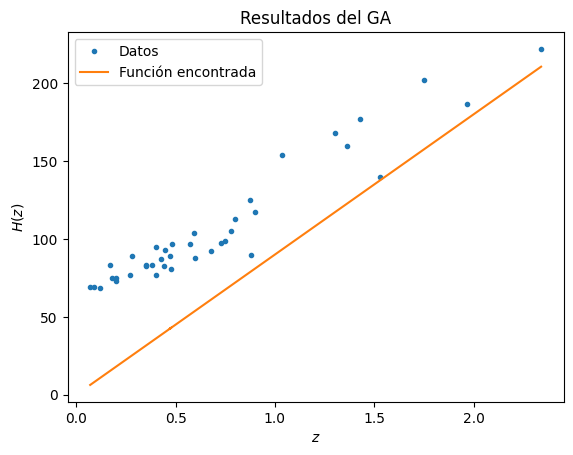

In [527]:
plt.plot(z, H, '.', label = 'Datos')
plt.plot(z, evaluada*90, label = 'Función encontrada')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.title('Resultados del GA')
plt.show()

In [528]:
def GA_2(num_generaciones, num_poblacion_inicial, poblacion_base, operaciones, valores_observados, porcentaje_seleccion, porcentaje_combinacion, porcentaje_mutacion):

    #num_seleccion = int(num_poblacion_inicial*(porcentaje_seleccion/100))
    Poblacion = []
    Seleccion_funciones = []
    Seleccion_Chi = []
    Generacion = []
    
    for n in range(0, num_generaciones):
        print('NUMERO_DE_GENERACION:' +str(n))
        if n == 0:
            P = Creador(num_poblacion_inicial, poblacion_base, operaciones)
            Poblacion.append(P)

            inicio_tiempo = time.time()
            S = Seleccionador(Poblacion[n], valores_observados, porcentaje_seleccion)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Seleccionador tomó {tiempo_transcurrido} segundos en ejecutarse.")


            S_f = S[0]
            print(S_f)
            S_Chi = S[1]
            Seleccion_funciones.append(S_f)
            Seleccion_Chi.append(S_Chi)

            R = Reproductor(Seleccion_funciones[n], operaciones, porcentaje_combinacion, Seleccion_Chi[n], porcentaje_mutacion)

            Generacion.append(R)

            print('NUEVA_GENERACION:' + str(Generacion[n]))

        else: 

            inicio_tiempo = time.time()
            S = Seleccionador(Generacion[n-1], valores_observados, porcentaje_seleccion)
            tiempo_transcurrido = time.time() - inicio_tiempo
            print(f"Seleccionador tomó {tiempo_transcurrido} segundos en ejecutarse.")
            
            S_f = S[0]
            S_Chi = S[1]
            Seleccion_funciones.append(S_f)
            Seleccion_Chi.append(S_Chi)

            if len(Seleccion_funciones[n]) == 1:
                print("Deteniendo el código porque len(Generacion[n]) == 1")
                break

            # Evaluar si todos los elementos de Seleccion_funciones son iguales al final de la iteración
            if all(elemento == Seleccion_funciones[n][0] for elemento in Seleccion_funciones[n]):
                print("Deteniendo el código porque todos los elementos de Seleccion_funciones son iguales al final de la iteración")
                break

            R = Reproductor(Seleccion_funciones[n], operaciones, porcentaje_combinacion, Seleccion_Chi[n], porcentaje_mutacion)
            
            Generacion.append(R)

            print('NUEVA_GENERACION:' + str(Generacion[n]))
            print('LONGITUD DE FUNCIONES SELECCIONADAS: ' +str(len(Seleccion_funciones[n])))
    

    
    Generacion[n-1] = Simplificador(Seleccion_funciones[n])
    print('NUEVA_GENERACION: ' +str(Seleccion_funciones[n]))

    return Generacion[-1]

## Falta: 

1. Mantener el numero de la poblacion constante

2. Crear un método para que, dentro de la población final, se encuentre al individuo con menor $\Chi^2$

In [529]:
def Evaluada(x):
    return np.log(x)**(2*np.exp(x)) - np.log(np.log(x)**np.exp(x))**np.exp(x)

# Leer hasta aquí. Luego: Primer y Segundo Intento de GA

In [530]:
def Combinador(funciones_seleccionadas, operaciones, porcentaje_combinacion, Chi_seleccionados): 

    #elegir el 20% con menor chi de los seleccionados
    mejor_seleccion = np.percentile(Chi_seleccionados, int(100 - porcentaje_combinacion)) 
    mejores_chi = Chi_seleccionados[Chi_seleccionados <= mejor_seleccion]
    mejores_indices = np.where(Chi_seleccionados <= mejor_seleccion)[0]
    mejores_funciones = [funciones_seleccionadas[i] for i in mejores_indices]
        
    combinados = mejores_funciones
    num_combinados = int(len(funciones_seleccionadas)*(porcentaje_combinacion/100))
    indices_que_no = mejores_indices
    funciones_a_combinar = np.delete(funciones_seleccionadas, indices_que_no)

    for n in range(0, len(funciones_a_combinar)):
        indice = random.randint(0, len(funciones_a_combinar)-1)
        expresion1 = funciones_a_combinar[n]
        expresion2 = funciones_a_combinar[indice]
        operacion = random.choice(operaciones)
        if operacion == 'comp':
            # Se pasan a funciones sympy
            x = symbols('x')
            expresiones = [expresion1, expresion2]
            #print(expresiones)
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            #print(f1)
            f2 = expresiones_sympy[1]
            #print(f2)
            # Se componen expresiones
            composicion = f1.subs(x, f2)
            #print(composicion)
            combinados.append(str(composicion))
        else: 
            expresion = f"{expresion1} {operacion} {expresion2}"
            combinados.append(expresion)

    return combinados

In [531]:
# Comprobacion de que Combinador esta bien

funciones_combinadas = Combinador(funciones_seleccionadas, operaciones, 80, Chi_seleccionados)
print(funciones_combinadas)
print(len(funciones_combinadas))

['log(exp(x))', 'x**2 / x', 'x**2 / x', 'x', 'x**2 - x ** x**2 - x', 'x / exp(x) - x / x', 'x / x + x / x', 'x**2 / exp(x) - x**2 / x**2', 'x / exp(x) ** x**2 / x**2', 'x**2 / x**2 ** x / exp(x)', 'log(x) / log(x) / x**2 / x**2', 'x**2 / x**2 * x**2 / x**2', 'x / exp(x) ** log(x) / log(x)', 'x / x / x**2 / x**2', 'x / x - x / exp(x)', 'x**2 - x ** x / exp(x)']
16


In [532]:
def Mutador(porcentaje_mutacion, funciones_combinadas, poblacion_base, operaciones):
    '''
    Seleccionador recibe: 
    1. Porcentaje que se desea de mutación
    2. Funciones anteriormente combinadas
    3. Población base de funciones

    Selecciona a un porcentaje de la poblacion de funciones combinadas 
    y les agrega una operacion base y una expresion tambien de la poblacion base

    Devuelve expresiones mutadas y sus respectivos indices en la lista de funciones combinadas
    '''
    num_mutacion = int(len(funciones_combinadas)*(porcentaje_mutacion/100))
    mutaciones = []
    funciones_a_mutar = []

    for n in range(0, num_mutacion): # range no cuenta el ultimo elemento
        if n == 0:
            expresion1 = random.choice(funciones_combinadas)
            funciones_a_mutar.append(expresion1)
        else:
            expresion1 = random.choice(funciones_combinadas)
            while expresion1 in funciones_a_mutar:
                expresion1 = random.choice(funciones_combinadas)
            funciones_a_mutar.append(expresion1)

        expresion2 = random.choice(poblacion_base)

        operacion = random.choice(operaciones)

        if operacion == 'comp':
            x = symbols('x')
            expresiones = [expresion1, expresion2]
            expresiones_sympy = [sympify(exp) for exp in expresiones] 
            f1 = expresiones_sympy[0]
            f2 = expresiones_sympy[1]
            # Se componen expresiones
            composicion = f1.subs(x, f2)
            mutaciones.append(str(composicion))
        else: 
            expresion = f"({expresion1}) {operacion} {expresion2}"
            mutaciones.append(expresion)
            
    #mutaciones = Simplificador(mutaciones)
    indices = [i for i, elem in enumerate(funciones_combinadas) if elem in funciones_a_mutar]

    return mutaciones, indices

In [533]:
# Comprobacion de que Mutador esta bien

funciones_mutadas, indices = Mutador(50, funciones_combinadas, poblacion_base, operaciones)

print(funciones_mutadas)
print(indices)

['(x**2 / x**2 * x**2 / x**2) - x**2', '(log(exp(x))) ** x**3', '(x / x + x / x) * x**4', '(x**2 / exp(x) - x**2 / x**2) - x**3', '(x / exp(x) - x / x) / exp(x)', '(x) / log(x)', '(x**2 - x ** x / exp(x)) / x**2', '(x**2 - x ** x**2 - x) - log(x)']
[0, 3, 4, 5, 6, 7, 11, 15]


In [534]:
def Nueva_Generacion(funciones_combinadas, mutaciones, indices):
    nueva_generacion = []

    i = 0
    for n in range(0, len(funciones_combinadas)):
        if n in indices:
            nueva_generacion.append(mutaciones[i])
            i += 1
        else:
            nueva_generacion.append(funciones_combinadas[n])
    
    nueva_generacion = Simplificador(nueva_generacion)
    
    return nueva_generacion

In [535]:
# Comprobar si Nueva_Generacion está bien

A = Nueva_Generacion(funciones_combinadas, funciones_mutadas, indices)

print(A)
print(len(A))

[1 - x**2, x, x, log(exp(x))**(x**3), 2*x**4, -x**3 + x**2*exp(-x) - 1, (x - exp(x))*exp(-2*x), x/log(x), 1/(x*exp(x)**(x**2)), x**(2 - 2**x)*exp(-x), x**(-4), -x**(x - 2)*exp(-x) + 1, x/(exp(x)**log(x)*log(x)), x**(-4), -x*exp(-x) + 1, x**2 - x - x**(x**2) - log(x)]
16


## Prueba 1 de código

Se van a procesar 30 generaciones para al final ver que función, en la décima generación, tiene el menor Chi^2.

In [536]:
def GA(num_generaciones, num_poblacion_inicial, población_base, operaciones, valores_observados, porcentaje_seleccion, porcentaje_combinacion, porcentaje_mutacion):

    num_seleccion = int(num_poblacion_inicial*(porcentaje_seleccion/100))
    num_mutacion = int(num_seleccion*(porcentaje_mutacion/100))
    Poblacion = []
    Seleccion_funciones = []
    Seleccion_Chi = []
    Combinacion = []
    Mutacion_funciones = []
    Mutacion_indices = []
    Generacion = []
    
    for n in range(0, num_generaciones):
        print(n)
        if n == 0:
            P = Creador(num_poblacion_inicial, poblacion_base, operaciones)
            Poblacion.append(P)

            S = Seleccionador(Poblacion[n], valores_observados, porcentaje_seleccion)
            S_f = S[0]
            S_Chi = S[1]
            Seleccion_funciones.append(S_f)
            Seleccion_Chi.append(S_Chi)

            C = Combinador(Seleccion_funciones[n], operaciones, porcentaje_combinacion, Seleccion_Chi[n])
            Combinacion.append(C)

            Mutacion = Mutador(porcentaje_mutacion, Combinacion[n], poblacion_base, operaciones)
            M_f = Mutacion[0]
            M_i = Mutacion[1]
            Mutacion_funciones.append(M_f)
            Mutacion_indices.append(M_i)

            N_G = Nueva_Generacion(Combinacion[n], Mutacion_funciones[n], Mutacion_indices[n])
            Generacion.append(N_G)
            print(Generacion)
        else: 
            S = Seleccionador(Generacion[n-1], valores_observados, porcentaje_seleccion)
            S_f = S[0]
            S_Chi = S[1]
            Seleccion_funciones.append(S_f)
            Seleccion_Chi.append(S_Chi)

            C = Combinador(Seleccion_funciones[n], operaciones, porcentaje_combinacion, Seleccion_Chi[n]) 
            Combinacion.append(C)

            Mutacion = Mutador(porcentaje_mutacion, Combinacion[n], poblacion_base, operaciones)
            M_f = Mutacion[0]
            M_i = Mutacion[1]
            Mutacion_funciones.append(M_f)
            Mutacion_indices.append(M_i)

            N_G = Nueva_Generacion(Combinacion[n], Mutacion_funciones[n], Mutacion_indices[n])
            Generacion.append(N_G)
            print(Generacion)
    
    Generacion[n] = Simplificador(Generacion[n])
    return Generacion[n]

In [537]:
primer_intento = GA(3, 100, ['x**3', 'x**4', '(x+1)', 'x**2'], ['*', '**', '/', '+', '-', 'comp'], z, 20, 80, 10)

0
[3.45806225e+000 1.14718685e+001 3.10488372e+001 2.43873578e+005
 2.19501385e+000 1.58632516e+001 0.00000000e+000 1.00000000e+011
 1.64346910e+004 1.00000000e+011 1.00000000e+011 1.00000000e+011
 3.41543753e+001 1.00000000e+011 1.64346910e+004 1.00000000e+011
 3.44123057e+000 0.00000000e+000 5.51789042e+000 0.00000000e+000
 6.17775134e+001 2.31109758e-001 3.10488372e+001 1.00000000e+011
 1.00920798e+001 1.84373121e-001 1.58632516e+001 1.00000000e+011
 1.95763059e+003 7.67890038e-002 2.53670677e+000 1.51768473e+000
 1.00920798e+001 1.02174147e+000 2.23317222e+000 1.00920798e+001
 2.29432445e+000 4.69377064e-001 1.84373121e-001 9.06066071e-002
 3.30217583e+002 1.62117266e+000 1.72791135e+003 1.00000000e+011
 7.70024895e+300 8.64267720e-001 2.31109758e-001 3.44123057e+000
 1.64346910e+004 2.29551756e+001 5.37086222e+002 1.00000000e+011
 1.14718685e+001 7.70024895e+300 1.96606422e+000 2.29035443e+001
 5.43515611e+000 1.64346910e+004 5.43406248e+000 9.16746349e-034
 3.41543753e+001 4.8665

<lambdifygenerated-13079>:2: RuntimeWarning: overflow encountered in power
  return x**(2**(x**4))
C:\Users\ximen\AppData\Local\Temp\ipykernel_9344\1304281419.py:19: RuntimeWarning: overflow encountered in square
  chi = np.sum((diferencia/desv_np)**2)
<lambdifygenerated-13081>:2: RuntimeWarning: invalid value encountered in log
  return log(log(x))
<lambdifygenerated-13082>:2: RuntimeWarning: invalid value encountered in power
  return log(x)**exp(x)
<lambdifygenerated-13083>:2: RuntimeWarning: overflow encountered in power
  return x**(3**exp(x))
<lambdifygenerated-13085>:2: RuntimeWarning: overflow encountered in power
  return x**(3**exp(x))
<lambdifygenerated-13087>:2: RuntimeWarning: overflow encountered in power
  return x**(2**exp(x))
<lambdifygenerated-13095>:2: RuntimeWarning: overflow encountered in power
  return x**(4**exp(x))
<lambdifygenerated-13099>:2: RuntimeWarning: invalid value encountered in power
  return log(x)**(x**3)
<lambdifygenerated-13115>:2: RuntimeWarning:

[[-exp(x), x, x, x, x, x**4*exp(-x), 1, x**4*exp(-x)/log(exp(x)), -x**(2**log(x)) + exp(x) - log(x), -x**2*log(x) + 1, x**3, x**2 - x**2/log(x) - log(x), -2*x**3 + log(exp(x)), -x**2 + log(x) - exp(-x)*log(x), -x**2 - x**(2**exp(x)) + exp(x), x**4*exp(-x), log(exp(x)), x**2*(-x**3 + x - 1), x**2*log(x)*log(exp(x)), 1]]
1
[5.46027205e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.67890038e-02 1.84373121e-01 9.06066071e-02
 1.11295574e+00 9.62714095e-01 2.32834244e+00 3.89175860e+00
 1.40925867e+01 1.54487863e+00 1.00000000e+11 7.67890038e-02
 9.16746349e-34 8.79011296e+01 1.62117266e+00 1.84373121e-01]
Las funciones seleccionadas por Seleccionador fueron: [x, x, x, x]
[[-exp(x), x, x, x, x, x**4*exp(-x), 1, x**4*exp(-x)/log(exp(x)), -x**(2**log(x)) + exp(x) - log(x), -x**2*log(x) + 1, x**3, x**2 - x**2/log(x) - log(x), -2*x**3 + log(exp(x)), -x**2 + log(x) - exp(-x)*log(x), -x**2 - x**(2**exp(x)) + exp(x), x**4*exp(-x), log(exp(x)), x**2*(-x**3 + x - 1), x**2*log(x)*

<lambdifygenerated-13186>:2: RuntimeWarning: overflow encountered in power
  return -x**2 - x**(2**exp(x)) + exp(x)


In [538]:
A = primer_intento
print(primer_intento)

[x, x, x, x]


### Veamos cual es la mejor funcion entre las funciones que entregó al final de la selección


In [539]:
porcentaje_final = 100 / len(primer_intento)
#print(primer_intento)

best_fit = Seleccionador(A, z, porcentaje_final)[0]
print(best_fit)


[0. 0. 0. 0.]
Las funciones seleccionadas por Seleccionador fueron: [x, x, x, x]
[x, x, x, x]


## La convertimos en una función tipo numpy

In [540]:
# Convertir de expresiones sympy a funciones de Python
funciones_python = [lambdify(x, expresion, 'numpy') for expresion in best_fit]

best_fit_python = funciones_python[0]

## Vamos a graficarla con respecto a los datos

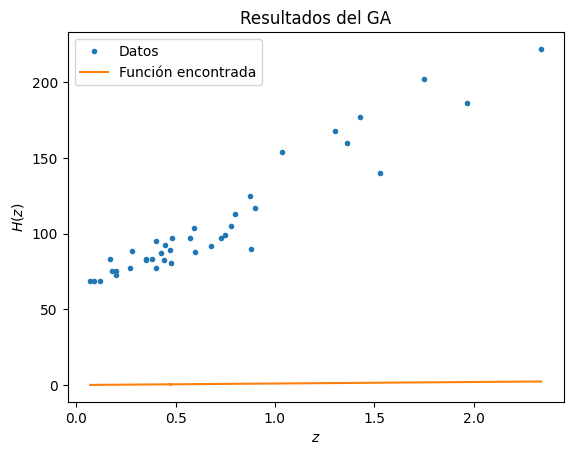

In [541]:
plt.plot(z, H, '.', label = 'Datos')
plt.plot(z, best_fit_python(z), label = 'Función encontrada')
plt.legend()
plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.title('Resultados del GA')
plt.show()